In [1]:
import os
os.chdir('/Users/Raphael/INRIA/travail/anHALytics/') #Select your working directory
cwd = os.getcwd()
import os.path
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
spec=['/','*',',','.','?','(',')'] 
mask = np.array(Image.open('cloud3.jpg'))


In [2]:
anHALytics={}
for x in os.listdir(cwd+'/json'):
    if x!='.DS_Store':
        anHALytics[x[:-5]]=pd.read_json(cwd+'/json/'+x)

subset_SIRENE=pd.read_json('/Users/Raphael/INRIA/travail/SIRENE/subset_SIRENE.json')
subset_SIRENE=subset_SIRENE[subset_SIRENE['SIEGE']==1]

In [3]:
table1=subset_SIRENE.groupby(['APEN700','LIBAPEN'],as_index=False).SIREN.count()
ctg={}
for x in list(table1['APEN700']):
    ctg[x]=table1['LIBAPEN'][table1['APEN700']==x].values[0]

In [4]:
def normalize(string,spec):
    string=string.lower()
    for x in spec:
        string=string.replace(x,'')
    #string=string.replace('s ','')
    return(string)

def del_small_char(string,l):
    string=string.split(' ')
    for i in range(len(string)-1,-1,-1):
        if len(string[i])<l:
            del string[i]
    return(' '.join(string))

def dico_word(string):
    d={}
    string=string.split(' ')
    for x in string:
        d[x]=d.get(x,0)+1
    return(d)

def limit_str(string,l):
    if len(string)>l:
        return(string[:l]+'...')
    return(string)

In [5]:
x=pd.merge(anHALytics['PUBLICATION'],anHALytics['DOCUMENT_ORGANISATION'],on='docID',how='left')
y=pd.merge(x,anHALytics['ORG_SIREN'], on='organisationID',how='left')
z=pd.merge(y,subset_SIRENE[['SIREN','LIBAPEN','APEN700']],on='SIREN',how='left')

del x
del y

In [8]:
summary=z.groupby(['APEN700','LIBAPEN'],as_index=False).docID.count()

fig={"data":[{
    "values":list(summary['docID']),
    "labels":list(summary['LIBAPEN'].apply(lambda x : limit_str(x,50))),
    "domain": {"x": [0, .48]},
    "text": list(summary['APEN700']),
    "name":"Code APE",
    "hoverinfo":"text+percent+name",
    "type": "pie",
    "marker":dict(line=dict(color='#000000', width=0.9))
    }],
     "layout": {
         "title":"Répartition des publications en fonction de l'acitivité de l'entreprise"
     }
    }
offline.iplot(fig)

In [20]:
summary.to_excel(cwd+'/Tables/Table4.xls')

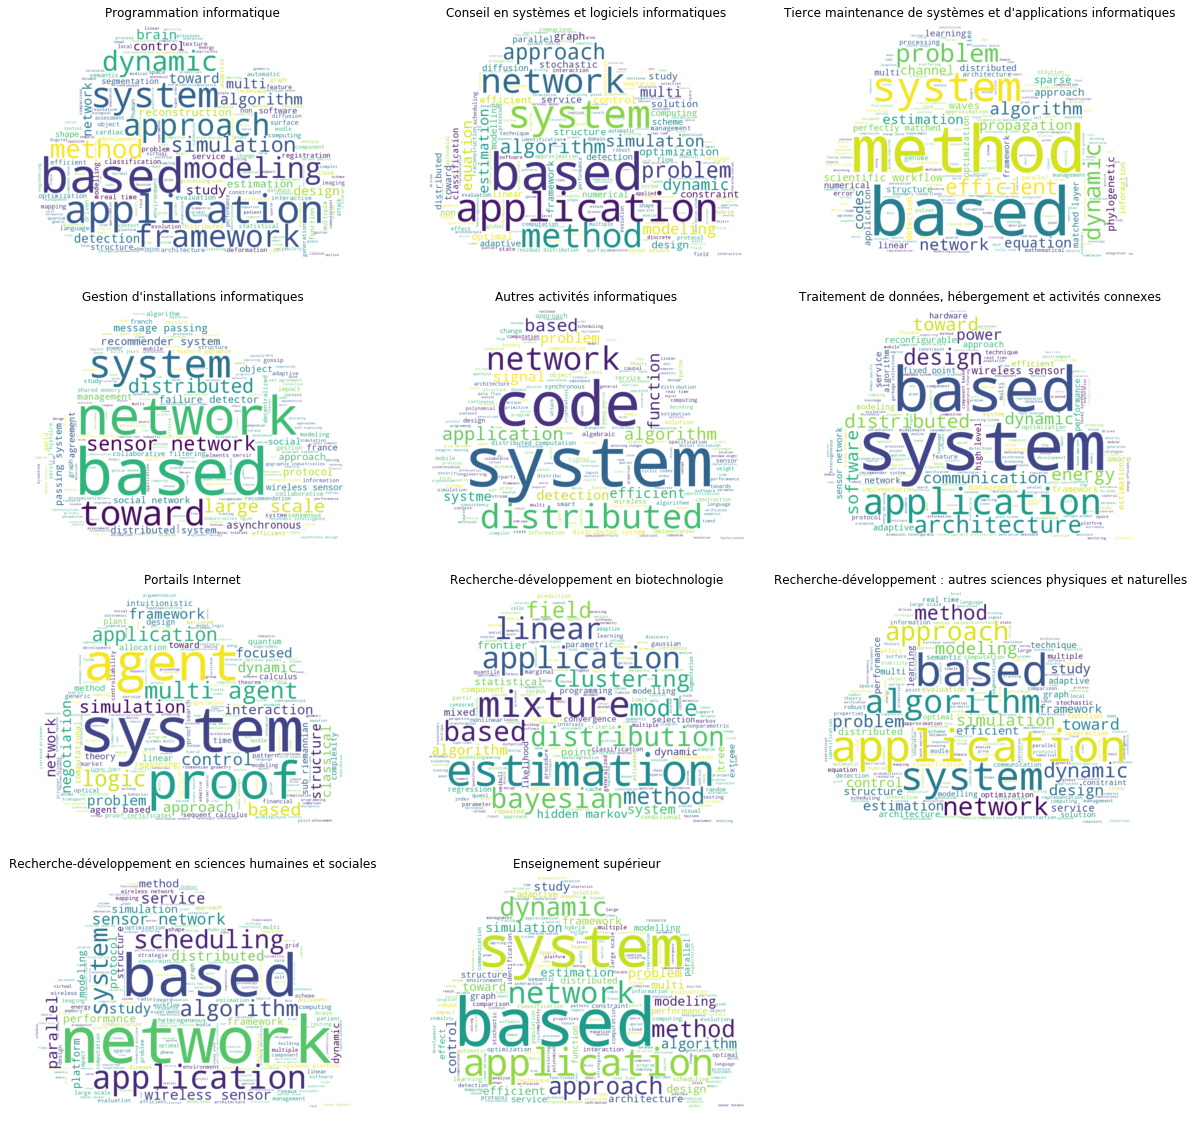

In [21]:
plt.figure(figsize=(20,20))
for i,x in enumerate(ctg):
    plt.subplot(4,3,i+1)
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',mask=mask)
    wordcloud.generate(' '.join(list(z['doc_title'][z['APEN700']==x].apply(lambda x : del_small_char(normalize(x,spec),5)).unique())))
    wordcloud.to_file(cwd+'/wordcloud/'+ctg[x]+'_freq.png')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(ctg[x])
    plt.axis("off")
plt.savefig('Clouds_freq.eps')
plt.show()

Le résultat n'est pas très pertinent puisqu'on génère des wordclouds uniquement basés sur les fréquences des mots dans chaque secteur d'activité. Donc une solution plus adaptée serait d'utiliser les tfidf des termes de chaque catégorie, et voir si les résultats sont plus pertinents.

In [9]:
words_col=list(set(' '.join(list(z['doc_title'].apply(lambda x : del_small_char(normalize(x,spec),5)).unique())).split(' ')))

In [10]:
words_df=pd.DataFrame(columns=words_col)

for x in ctg:
    json=dico_word(' '.join(list(z['doc_title'][z['APEN700']==x].apply(lambda x : del_small_char(normalize(x,spec),5)).unique())))
    words_df=words_df.append(json,ignore_index=True)

In [11]:
words_df=words_df.fillna(0)

words_matrix=words_df.as_matrix()

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

tfidf = transformer.fit_transform(words_matrix) #matrice des tfidf de chaque mot

/Users/Raphael/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1037: RuntimeWarning:

divide by zero encountered in true_divide



In [13]:
words_tfidf_df=pd.DataFrame(tfidf.toarray(),columns=words_col)
stopwords=STOPWORDS
stopwords.update(['model','using','models','analysis','images','image','networks','method','approach',
                  'based','systems','control','application','distributed']) #add any stopwords we think would benefit for the representation
for x in stopwords:
    try:
        del words_tfidf_df[x]
    except:
        None

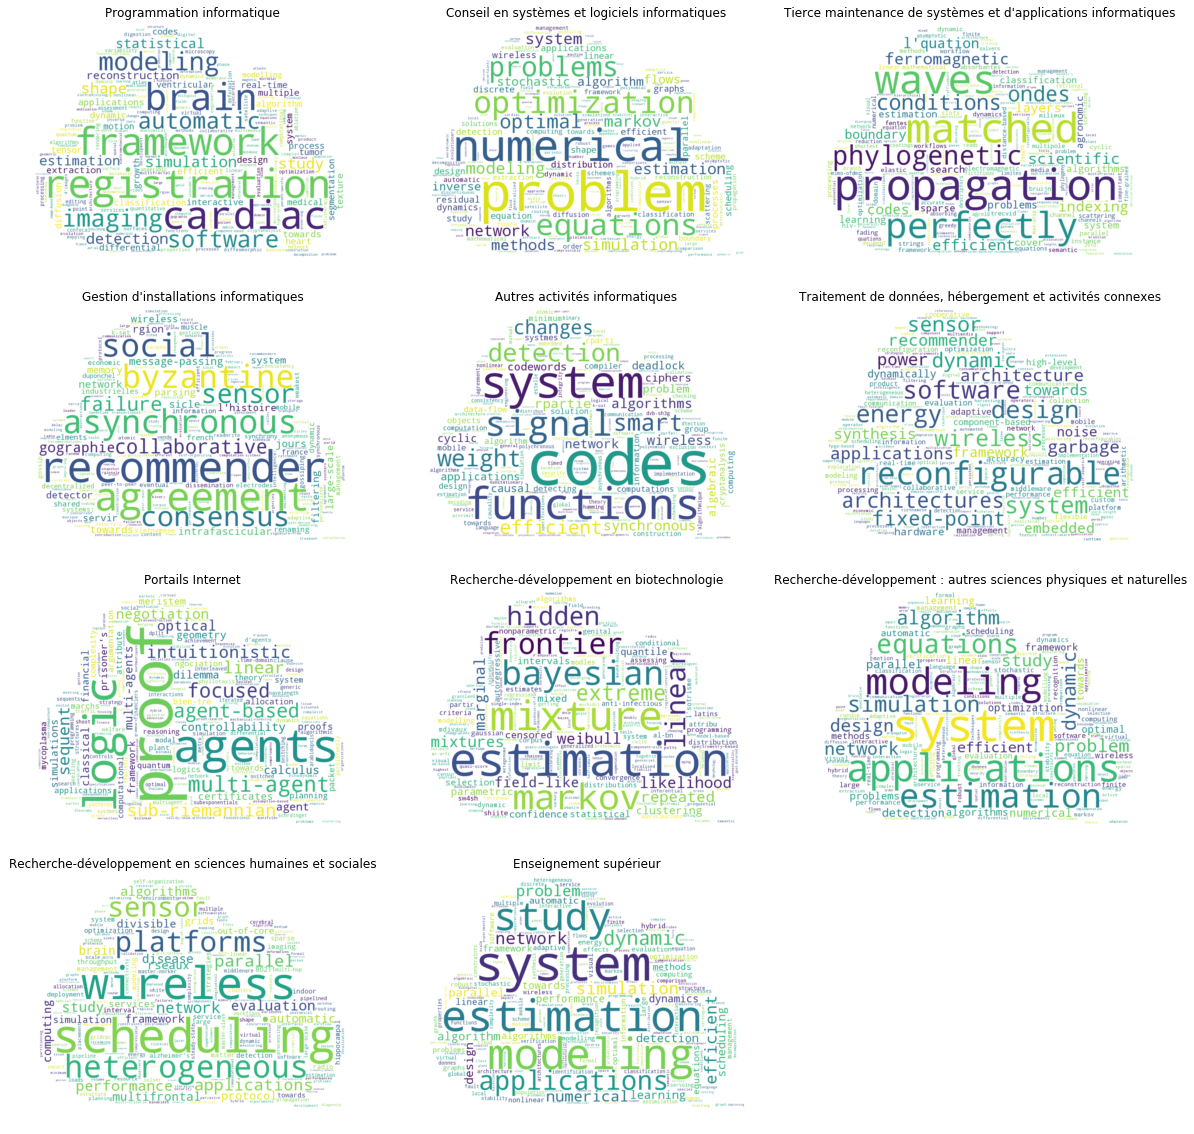

In [14]:
plt.figure(figsize=(20,20))
for i,x in enumerate(ctg):
    plt.subplot(4,3,i+1)
    wc=WordCloud(stopwords=STOPWORDS,mask=mask,background_color="white")
    wc.generate_from_frequencies(frequencies=words_tfidf_df.iloc[i].to_dict())
    wc.to_file(cwd+'/wordcloud/'+ctg[x]+"tfidf.png")
    plt.imshow(wc, interpolation='bilinear')
    plt.title(ctg[x])
    plt.axis("off")
plt.savefig('Clouds_tfidf.png')
plt.show()

Les résultats semblent effectivement plus pertinents en prennant en compte les tfidf plutôt que les simples fréquences des mots.